# Setup

## Install libraries

In [ ]:
!pip install scikit-fda scikit-misc &> /dev/null

## Load data and libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skmisc.loess import loess
from scipy.interpolate import splev, interp1d
from sklearn.linear_model import LinearRegression

from numpy.linalg import inv
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def read_public_gdrive_file(file_id):
    url = 'https://drive.google.com/uc?id={}'.format(file_id)
    return pd.read_csv(url)

Coding3_Data = read_public_gdrive_file("1AIk_wJX6oxV3c24F2IwYmWxp3HwzLVI3")
Sales_Transactions_Dataset_Weekly = read_public_gdrive_file("15GF8-dg99pmpHhL8MgVckCSJFliOPLs4")
Coding3_dataH = read_public_gdrive_file("11_m1wTLR19plswkIYf0023HOudSVIA0d")

# Part I: Optimal span for LOESS

          x         y
0  0.009496  2.692822
1  0.039996  0.566787
2  0.045770 -0.133373
3  0.113703 -2.696734
4  0.159046 -0.145285
(30, 2)
2.2414734958901574
1.489205632621718


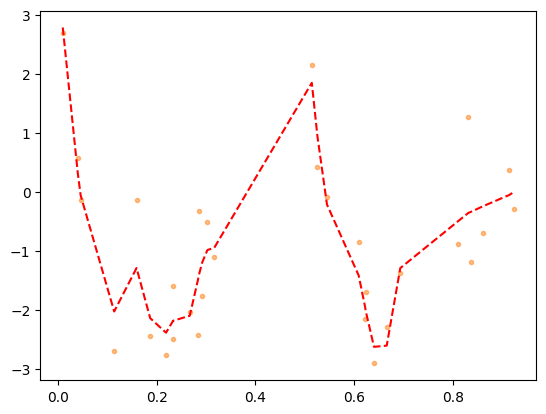

In [ ]:
df = Coding3_Data
print(df.head())
print(df.shape)

model = loess(df['x'], df['y'], span=0.25)
model.fit()
pred = model.predict(df['x'])

plt.plot(df['x'], pred.values, '--', c='r')
plt.scatter(df['x'], df['y'], marker='.', alpha=0.5, c='tab:orange')

# resid = model.outputs.fitted_residuals
# trace = model.outputs.diagonal
# avg_trace = np.repeat(np.mean(trace), len(trace))

# print(np.mean((resid/(1-trace))**2))        # LOO-CV error
# print(np.mean((resid/(1-avg_trace))**2))    # G-CV error

In [ ]:
# print(dir(model.outputs)) # 'activated', 'diagonal', 'divisor', 'enp', 'family', 'fitted_residuals', 'fitted_values', 'n', 'one_delta', 'p', 'pseudovalues', 'residual_scale', 'robust', 'trace_hat', 'two_delta'
print(model.outputs.diagonal)
print(sum(model.outputs.diagonal))
print(model.outputs.trace_hat)

[0.83195412 0.32909029 0.36118215 0.84431984 0.54174852 0.69407453
 0.39996849 0.38243453 0.39122847 0.93089364 0.30023623 0.29804677
 0.31204548 0.31367168 0.90753699 0.79208676 0.3508892  0.8165808
 0.41095728 0.29308114 0.29297312 0.42753478 0.50484046 0.95737064
 0.89438952 0.27690837 0.30330612 0.57499098 0.41849499 0.62431703]
15.777152922113022
15.777152922113022


## Naive LOO-CV prediction error

In [ ]:
from sklearn.model_selection import LeaveOneOut

def compute_loess_prediction(X_train, y_train, span, X_test):
    model = loess(X_train, y_train, span=span, surface='direct')
    model.fit()
    return model.predict(X_test).values

def compute_naive_loocv(X, y, span):
    result = 0
    for train_indexes, test_indexes in LeaveOneOut().split(X):
        X_train, X_test = X[train_indexes], X[test_indexes]
        y_train, y_test = y[train_indexes], y[test_indexes]
        y_pred = compute_loess_prediction(X_train, y_train, span, X_test)
        result += np.abs(y_test[0] - y_pred[0])**2
    return result / len(y)

spans = np.arange(0.2, 0.9 + 0.05, 0.05)    # 0.20, 0.25, ..., 0.90
for span in spans:
    X = df['x'].to_numpy()
    y = df['y'].to_numpy()
    print("span: {span: <10} naive_loocv: {naive_loocv: <25}".format(
        span=f'{span:.2f}',
        naive_loocv=compute_naive_loocv(X, y, span),
    ))

span: 0.20       naive_loocv: 12.416166780180072       
span: 0.25       naive_loocv: 1.5374171285851064       
span: 0.30       naive_loocv: 1.5029569363663169       
span: 0.35       naive_loocv: 1.240115246417454        
span: 0.40       naive_loocv: 1.2232152682693014       
span: 0.45       naive_loocv: 1.1319595630312622       
span: 0.50       naive_loocv: 1.1214625767510844       
span: 0.55       naive_loocv: 1.1663694681123027       
span: 0.60       naive_loocv: 1.1721453411246567       
span: 0.65       naive_loocv: 1.2284122532990744       
span: 0.70       naive_loocv: 1.273252922385969        
span: 0.75       naive_loocv: 1.3197651776545158       
span: 0.80       naive_loocv: 1.5142187783728251       
span: 0.85       naive_loocv: 1.7924943996621396       
span: 0.90       naive_loocv: 1.8786430145980142       


## Fast LOO-CV & G-CV prediction error

In [ ]:
# model = loess(df['x'], df['y'], span=0.25)
# pred = model.predict(df['x'])

# use formalas provided in lecture notes
# https://liangfgithub.github.io/Notes/lec_W5_NonlinearRegression.pdf
# https://campuswire.com/c/G06C55090/feed/291

def compute_fast_loocv(residuals, trace):
    return np.mean((residuals/(1-trace))**2)

def compute_fast_gcv(residuals, trace):
    avg_trace = np.repeat(np.mean(trace), len(trace))
    return np.mean((residuals/(1-avg_trace))**2)

def compute_fast_pred_error(X, y, span):
    model = loess(df['x'], df['y'], span=span)
    model.fit()
    residuals = model.outputs.fitted_residuals
    trace = model.outputs.diagonal
    return {
        "fast_loocv": compute_fast_loocv(residuals, trace),
        "fast_gcv": compute_fast_gcv(residuals, trace),
    }

spans = np.arange(0.2, 0.9 + 0.05, 0.05)    # 0.20, 0.25, ..., 0.90
pred_errors = []
for span in spans:
    X = df['x'].to_numpy()
    y = df['y'].to_numpy()
    pred_error = compute_fast_pred_error(X, y, span)
    pred_errors.append({"span": span, **pred_error})
    print("span: {span: <10} fast_loocv: {fast_loocv: <25} fast_gcv: {fast_gcv: <25}".format(
        span=f'{span:.2f}',
        **pred_error
    ))

def get_optimal_spans(pred_errors: pd.DataFrame):
    optimal_spans = {}
    for computation in ['fast_loocv', 'fast_gcv']:
        condition = pred_errors[computation]==pred_errors[computation].min()
        optimal_span = round(pred_errors[condition]['span'].iloc[0], 2)
        optimal_spans[computation] = optimal_span
    return optimal_spans


pred_errors = pd.DataFrame(pred_errors)
optimal_spans = get_optimal_spans(pred_errors)
print("fast_loocv optimal span: {}".format(optimal_spans["fast_loocv"]))
print("fast_gcv optimal span: {}".format(optimal_spans["fast_gcv"]))

span: 0.20       fast_loocv: 12.415910699869332        fast_gcv: 2.1101618419429564       
span: 0.25       fast_loocv: 2.2414734958901574        fast_gcv: 1.489205632621718        
span: 0.30       fast_loocv: 1.5029798111583716        fast_gcv: 1.1901098446318241       
span: 0.35       fast_loocv: 1.2591747084691483        fast_gcv: 1.1744229564766884       
span: 0.40       fast_loocv: 1.1903799279913378        fast_gcv: 1.1025399038231012       
span: 0.45       fast_loocv: 1.1568121230625679        fast_gcv: 1.0625034645069502       
span: 0.50       fast_loocv: 1.1256523403714556        fast_gcv: 1.0418328786112798       
span: 0.55       fast_loocv: 1.1796637523744389        fast_gcv: 1.1188405514998314       
span: 0.60       fast_loocv: 1.1794641625428166        fast_gcv: 1.1192688072551895       
span: 0.65       fast_loocv: 1.2509138273813027        fast_gcv: 1.1805847769313835       
span: 0.70       fast_loocv: 1.5535622642533482        fast_gcv: 1.5190908128135598       

## Plot Fitted Curve(s)

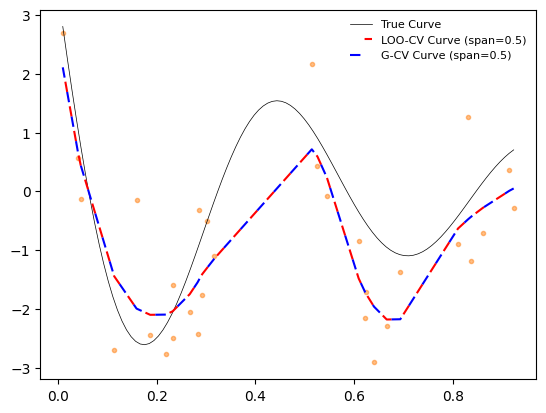

In [ ]:
plt.scatter(df['x'], df['y'], marker='.', alpha=0.5, c='tab:orange')

true_x = np.linspace(min(df['x']), max(df['x']), 100)
true_y = np.sin(12*(true_x+0.2))/(true_x+0.2)
plt.plot(true_x, true_y, c='black', linewidth=0.5, label='True Curve')

for computation, span in optimal_spans.items():

    model = loess(df['x'], df['y'], span=span)
    model.fit()
    pred = model.predict(df['x'])

    if computation == "fast_loocv":
        plt.plot(df['x'], pred.values, linestyle=(5, (5, 7)), color='red', label=f'LOO-CV Curve (span={span})')
    if computation == "fast_gcv":
        plt.plot(df['x'], pred.values, linestyle=(0, (5, 7)), color='blue', label=f'G-CV Curve (span={span})')

plt.legend(fontsize=8, markerscale=1.5, edgecolor='white')

# Part II: Clustering time series

## Data Cleaning

In [ ]:
df = Sales_Transactions_Dataset_Weekly
# print(df.dtypes.to_string())
# {Product_Code}:str, {W0, W1, ..., W51}:int64, {MIN, MAX}:int64, {Normalized 0, Normalized 1, ..., Normalized 51}:float64
# print(df.head())
# print(df.shape) # (811, 107)

# This dataset contains weekly purchased quantities of 811 products over 52 weeks, resulting in each product having a time series with 52 data points.
# Each row represents a products, W_i = how many units of a product was purchased in week i
# The MIN/MAX columns are the MIN/MAX of weekly purchased units for the given product
print((df.iloc[0]['MIN'], df.iloc[0, 1:53].min()))
print((df.iloc[0]['MAX'], df.iloc[0, 1:53].max()))

# Normalize each time series by removing its mean. Store the de-meaned data in an 811-by-52 matrix X
# This means we only need the W_i columns (52/107 fields)
df = df.iloc[:, 1:53]
print(df.head())
print(df.shape) # (811, 52)

# Apply mean centering to each row
df = df.apply(lambda x: x-x.mean(), axis=1)
# print(df.iloc[0,0]-df.iloc[0].mean())   # validate
print(df.head())

(3, 3)
(21, 21)
   W0  W1  W2  W3  W4  W5  W6  W7  W8  W9  ...  W42  W43  W44  W45  W46  W47  \
0  11  12  10   8  13  12  14  21   6  14  ...    4    7    8   10   12    3   
1   7   6   3   2   7   1   6   3   3   3  ...    2    4    5    1    1    4   
2   7  11   8   9  10   8   7  13  12   6  ...    6   14    5    5    7    8   
3  12   8  13   5   9   6   9  13  13  11  ...    9   10    3    4    6    8   
4   8   5  13  11   6   7   9  14   9   9  ...    7   11    7   12    6    6   

   W48  W49  W50  W51  
0    7    6    5   10  
1    5    1    6    0  
2   14    8    8    7  
3   14    8    7    8  
4    5   11    8    9  

[5 rows x 52 columns]
(811, 52)
         W0        W1        W2        W3        W4        W5        W6  \
0  1.365385  2.365385  0.365385 -1.634615  3.365385  2.365385  4.365385   
1  3.019231  2.019231 -0.980769 -1.980769  3.019231 -2.980769  2.019231   
2 -1.692308  2.307692 -0.692308  0.307692  1.307692 -0.692308 -1.692308   
3  3.730769 -0.269231  4.7

## NCS Basis Functions

In [ ]:
# provided in Python_W5_RegressionSpline.ipynb
# https://campuswire.com/c/G06C55090/feed/286
# https://campuswire.com/c/G06C55090/feed/7

# converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3

    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0

        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oright, :] = xr @ tt

        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis

(52, 9)


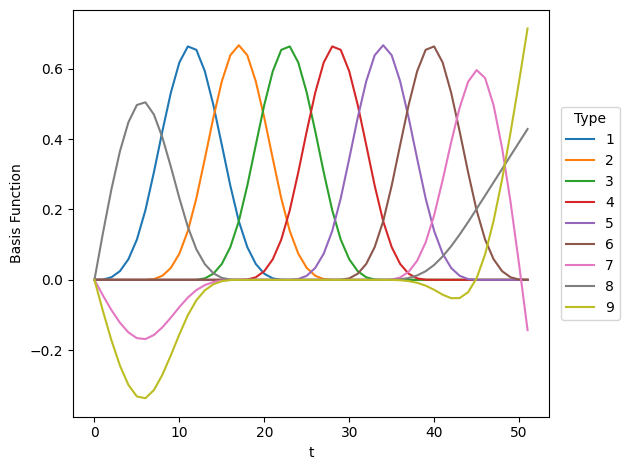

In [ ]:
week_idx = np.arange(1, 52+1, 1) # [1, 52]
F = ns(week_idx, df=9)
print(F.shape)

plt.plot(F)
plt.xlabel("t")
plt.ylabel("Basis Function")
plt.legend(np.arange(1,9+1,1), title="Type",
           bbox_to_anchor=(1.01, 0.5), loc="center left")
plt.tight_layout()

## Fitting NCS

(811, 52)
[ 3.64267184 -2.73271956 -1.31920655 -2.46829938 -0.68232207  1.99720317
 -5.42605474 -0.50977579 -4.16784959]
9


Text(0, 0.5, 'Sales')

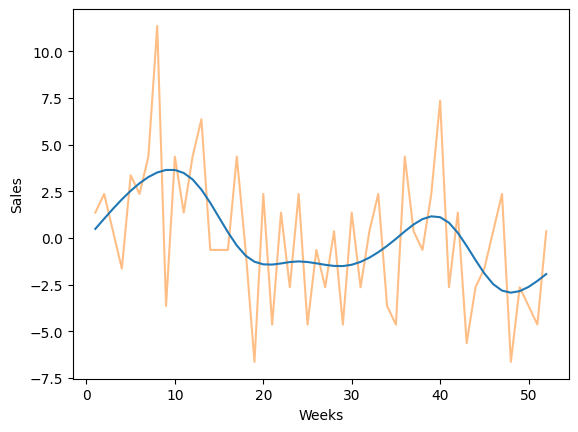

In [ ]:
# Test fit one product
X = df.to_numpy()
print(X.shape)

fit = LinearRegression().fit(F, X[0])
pred_y = fit.predict(F)
coefficients = fit.coef_
print(coefficients)
print(len(coefficients))

plt.plot(week_idx, X[0], alpha=0.5, c='tab:orange')
plt.plot(week_idx, interp1d(x=week_idx, y=pred_y)(week_idx))
plt.xlabel("Weeks")
plt.ylabel("Sales")

In [ ]:
from numpy.linalg import inv

# fit all products using provided formula
# https://liangfgithub.github.io/Coding/Coding3.html#Task8
B = inv(np.dot(F.T, F)).dot(F.T).dot(X.T).T
print(B.shape)
print(B[0])

(811, 9)
[ 3.97623613 -2.15466844 -0.87231507 -1.9512264  -0.2026932   2.49663618
 -5.15796219  0.6460706  -4.11650466]


In [ ]:
from sklearn.metrics import mean_squared_error

# attempt to corroborate approaches
# results are close but not the same: ask?
min_mse = 100
min_linalg_coefficients = None
for linalg_coefficients in B:
    mse = mean_squared_error(linalg_coefficients, coefficients)
    if mse < min_mse:
        min_mse = mse
        min_linalg_coefficients = linalg_coefficients

print(min_mse)
print(B[0] == min_linalg_coefficients )
print(min_linalg_coefficients)
print(coefficients)

0.31138363120134177
[ True  True  True  True  True  True  True  True  True]
[ 3.97623613 -2.15466844 -0.87231507 -1.9512264  -0.2026932   2.49663618
 -5.15796219  0.6460706  -4.11650466]
[ 3.64267184 -2.73271956 -1.31920655 -2.46829938 -0.68232207  1.99720317
 -5.42605474 -0.50977579 -4.16784959]


## Clustering Matrix B

Cluster 0: (601, 601)
Cluster 1: (28, 28)
Cluster 2: (63, 63)
Cluster 3: (54, 54)
Cluster 4: (37, 37)
Cluster 5: (28, 28)


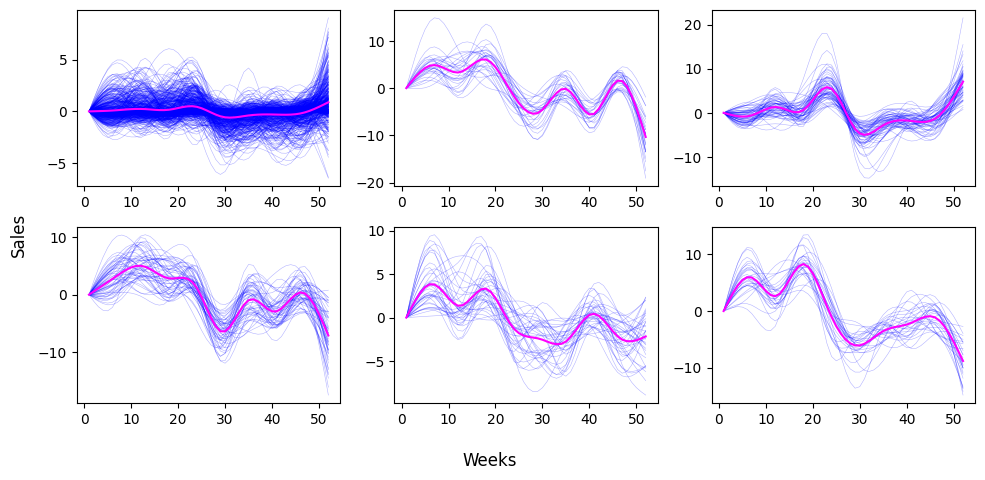

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(B)
# print(kmeans.labels_)
# print(kmeans.cluster_centers_)

def get_cluster(data, kmeans, label: int):
    cluster_idx = (kmeans.labels_ == label).astype(int)
    cluster_arrays = data[cluster_idx.astype(bool)]
    cluster_center = kmeans.cluster_centers_[label]
    print(f"Cluster {label}: {(sum(cluster_idx), len(cluster_arrays))}")
    return cluster_arrays, cluster_center

fig, axes = plt.subplots(nrows=2, ncols=3)
plot_lookup = {
    0: axes[0][0], 1: axes[0][1], 2: axes[0][2],
    3: axes[1][0], 4: axes[1][1], 5: axes[1][2],
}

for cluster in range(6):
    subplot = plot_lookup[cluster]
    cluster_coefficients, cluster_center = get_cluster(B, kmeans, cluster)
    for coefficients in cluster_coefficients:
        subplot.plot(week_idx, F.dot(coefficients), color='blue', alpha=0.3, linewidth=0.4)
    subplot.plot(week_idx, F.dot(cluster_center), color='fuchsia', linewidth=1.5)

fig.supxlabel("Weeks")
fig.supylabel("Sales")
fig.set_figwidth(10)
fig.tight_layout()

## Clustering Matrix X

Cluster 0: (541, 541)
Cluster 1: (40, 40)
Cluster 2: (117, 117)
Cluster 3: (26, 26)
Cluster 4: (37, 37)
Cluster 5: (50, 50)


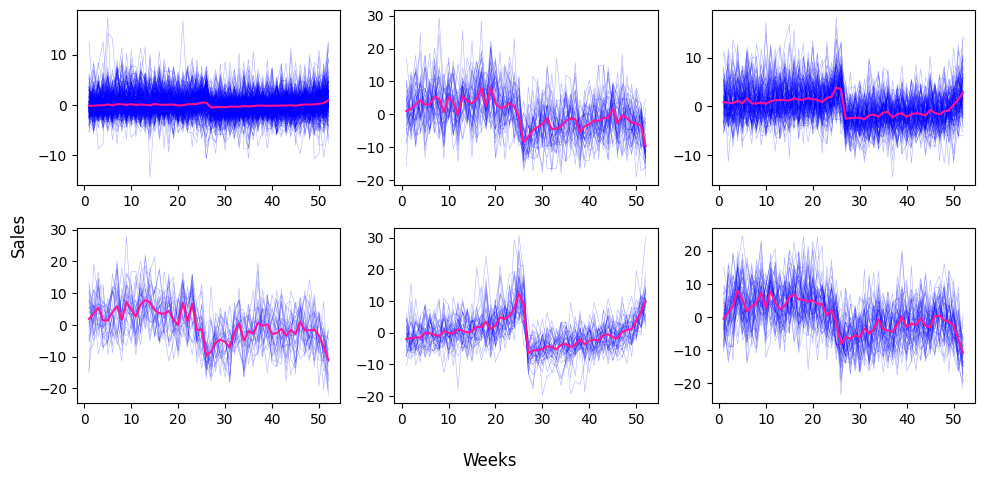

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(X)
# print(kmeans.labels_)
# print(kmeans.cluster_centers_)

fig, axes = plt.subplots(nrows=2, ncols=3)
plot_lookup = {
    0: axes[0][0], 1: axes[0][1], 2: axes[0][2],
    3: axes[1][0], 4: axes[1][1], 5: axes[1][2],
}

for cluster in range(6):
    subplot = plot_lookup[cluster]
    cluster_sales, cluster_center = get_cluster(X, kmeans, cluster)
    for sales in cluster_sales:
        subplot.plot(week_idx, sales, color='blue', alpha=0.3, linewidth=0.4)
    subplot.plot(week_idx, cluster_center, color='deeppink', linewidth=1.5)

fig.supxlabel("Weeks")
fig.supylabel("Sales")
fig.set_figwidth(10)
fig.tight_layout()

# Part III: Ridgeless and double descent

## Data Cleaning

In [ ]:
"""
Ridgeless is essentially linear regression using all features. When pn−1, one can apply PCA or SVD and then fit a linear model.
It's called ridgeless because it's the same as running a ridge regression with lambda being zero.
"""
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# we want PCR with the scale = FALSE option, implying that we’ll center each column of the design matrix
#       from the training data without scaling, which is the default behavior of sklearn.decomposition.PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

# decent summary of "ridgeless" procedure: https://campuswire.com/c/G06C55090/feed/317

data = Coding3_dataH.to_numpy()
y, X = data[:, 0], data[:, 1:]
# print(X[0, :10])
# print(y.shape)
# print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    # X, y, test_size=0.25, random_state=0
    X, y, test_size=0.75, random_state=0
)

## Exploring Ridgeless

In [ ]:
pca = PCA().fit(X_train)
print(len(pca.singular_values_))
print(pca.singular_values_[:10])
print(pca.singular_values_[-10:])

126
[11.39728328  6.00881414  5.73943777  4.91564947  4.47700762  4.27913947
  4.02046509  3.79372907  3.76816049  3.63030195]
[3.51907181e-01 3.30131414e-01 3.23135966e-01 3.09857150e-01
 3.00654702e-01 2.75876290e-01 2.58430597e-01 2.43927270e-01
 1.73895101e-01 7.95903947e-15]


In [ ]:
F_train = pca.transform(X_train)
print(F_train[0, :10])
print(F_train.shape)

component_idx = (pca.singular_values_ > 1e-10)
k = sum(component_idx)
# print(component_idx.shape)
# print(component_idx)

F_train = F_train[:, :k]
print(F_train.shape)

[ 1.49974015 -0.33266974  0.55073673  0.12523133  0.00749252  0.37849393
 -0.05595712 -0.30982896 -0.09342603  0.55514716]
(126, 126)
(126, 125)


In [ ]:
# Ridge Estimator:
#       https://online.stat.psu.edu/stat508/lesson/5/5.1
#       https://liangfgithub.github.io/Coding/Coding2_Part2_Python.html#PCR
#       Don't really understand: ask?

B = y_train.T @ F_train / np.sum(F_train**2, axis=0)                # Ridgeless estimator
# B = inv(np.dot(F_train.T, F_train)).dot(F_train.T).dot(y_train)   # OLS estimator

print(B.shape)
intercept = np.mean(y_train)

(125,)


In [ ]:
F_test = pca.transform(X_test)[:, :k]
print(X_test.shape)
print(F_test.shape)

(379, 240)
(379, 125)


In [ ]:
"""
Compute training and test error using 'ridgeless estimator'
"""

y_pred = F_train.dot(B) + intercept
print((y_pred.shape, y_train.shape))
mse = mean_squared_error(y_train, y_pred)
print(mse)

y_pred = F_test.dot(B) + intercept
print((y_pred.shape, y_test.shape))
mse = mean_squared_error(y_test, y_pred)
print(mse)

((126,), (126,))
4.223528417348913e-28
((379,), (379,))
0.09765642692220548


In [ ]:
"""
Ideally, your training error should align with the RSS derived from a standard linear regression model.
This block is meant to validate that the training and test errors are relatively similar.
"""

from sklearn.linear_model import LinearRegression as lm

model = lm().fit(F_train, y_train)

y_pred = model.predict(F_train)
print((y_pred.shape, y_train.shape))
mse = mean_squared_error(y_train, y_pred)
print(mse)

y_pred = model.predict(F_test)
print((y_pred.shape, y_test.shape))
mse = mean_squared_error(y_test, y_pred)
print(mse)

((126,), (126,))
6.241235832477747e-31
((379,), (379,))
0.09765642692220379


## Ridgeless Function

In [ ]:
def ridgeless(X_train, X_test, y_train, y_test):

    pca = PCA().fit(X_train)
    F_train = pca.transform(X_train)
    k = sum(pca.singular_values_ > 1e-10)

    F_train = F_train[:, :k]
    F_test = pca.transform(X_test)[:, :k]

    B = y_train.T @ F_train / np.sum(F_train**2, axis=0)
    intercept = np.mean(y_train)

    train_mse = mean_squared_error(y_train, F_train.dot(B) + intercept)
    test_mse = mean_squared_error(y_test, F_test.dot(B) + intercept)
    return {"train_mse": train_mse, "test_mse": test_mse}
    # return {"train_rss": train_mse*len(y_train), "test_rss": test_mse*len(y_test)}

print(ridgeless(X_train, X_test, y_train, y_test))

{'train_mse': 4.223528417348913e-28, 'test_mse': 0.09765642692220548}


## Simulation Study

In [ ]:
test_errors = np.empty([30, 236], dtype=float) # 7080 simulations
print(test_errors.shape)
for i in range(30):
    for d in range(5, 241):
        X_train, X_test, y_train, y_test = train_test_split(
            X[:, :d], y, test_size=0.75, random_state=0
        )
        test_error = ridgeless(X_train, X_test, y_train, y_test)
        test_errors[i, d-5] = test_error["test_mse"]
        # print(test_error)
    print(f"iteration: {i+1}")

In [ ]:
# print(test_errors)
# print(np.median(test_errors, axis=0))
print(np.log(np.median(test_errors, axis=0))[:10])

[-1.9581683  -1.96891461 -1.96850161 -1.96617494 -1.97404954 -1.97291699
 -2.01814969 -2.03278048 -2.02479415 -2.04605479]


Text(0, 0.5, 'Log of Test Error')

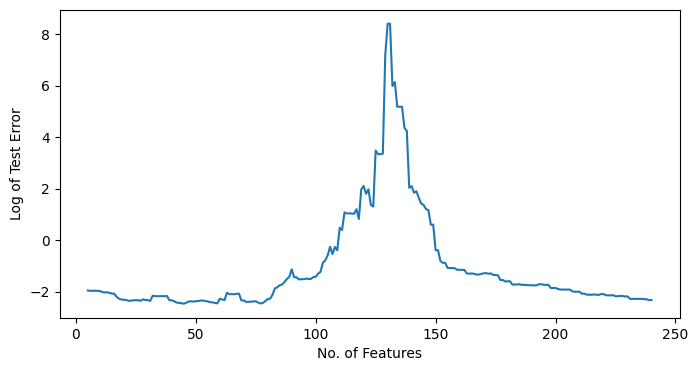

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(range(5, 241), np.log(np.median(test_errors, axis=0)))
plt.xlabel("No. of Features")
plt.ylabel("Log of Test Error")